# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import torch, torchvision
import torch.optim as optim
import torch.nn as nn
import torch.utils.data as data
import numpy as np

# Constants

In [2]:
GOOGLE_COLAB_VERSION = False
VALIDATION_PERCENTAGE = 0.20

# Setting up device

In [3]:
# device = torch.device("mps")
device = torch.device("cpu")
device

device(type='cpu')

In [4]:
if GOOGLE_COLAB_VERSION:
    from google.colab import drive
    drive.mount('/content/drive')
    print(torch.cuda.is_available())
    import os
    os.chdir("/content/drive/My Drive/SSNE_repo/SSNE/miniprojekt2")
    device = torch.device("cuda") 
    print(device)

# Seeds

In [5]:
# torch.manual_seed(42)


import os
import random

def set_all_seeds(seed):
    os.environ["PL_GLOBAL_SEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_all_seeds(42)

# Get Data

In [6]:
df = pd.read_csv('train_data.csv')

# Modify data

In [7]:
df['TimeToBusStop'] = df['TimeToBusStop'].map({'0~5min': 1, '5min~10min': 2, '10min~15min': 3})
df['TimeToSubway'] = df['TimeToSubway'].map({'0-5min': 1, '5min~10min': 2, '10min~15min': 3, '15min~20min': 4, 'no_bus_stop_nearby': 5})

In [8]:
def numerical_into_categorical(x):
    return pd.cut(x=x, bins=[x.min() - 1, 100000, 350000, x.max() + 1], labels=[0,1,2])


df['class'] = numerical_into_categorical(df['SalePrice'])

In [9]:
df = df.drop(columns='SalePrice')

## Split into train and validation

In [10]:
TRAIN_VALID_THRESHOLD = round((1-VALIDATION_PERCENTAGE) * df.shape[0])

In [11]:
valid_df = df.sample(frac = VALIDATION_PERCENTAGE)
train_df = df.drop(valid_df.index)

In [12]:
TRAIN_VALID_THRESHOLD

3299

In [13]:
# check dtypes
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3299 entries, 0 to 4121
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   YearBuilt                  3299 non-null   int64   
 1   Size(sqf)                  3299 non-null   int64   
 2   Floor                      3299 non-null   int64   
 3   HallwayType                3299 non-null   object  
 4   HeatingType                3299 non-null   object  
 5   AptManageType              3299 non-null   object  
 6   N_Parkinglot(Ground)       3299 non-null   float64 
 7   N_Parkinglot(Basement)     3299 non-null   float64 
 8   TimeToBusStop              3299 non-null   int64   
 9   TimeToSubway               3299 non-null   int64   
 10  N_manager                  3299 non-null   float64 
 11  N_elevators                3299 non-null   float64 
 12  SubwayStation              3299 non-null   object  
 13  N_FacilitiesInApt          3299 n

In [14]:
# split into X and y
target = 'class'

## split training data
y_train_df = train_df[target]
X_train_df = train_df.drop(columns=target)

## split validation data
y_valid_df = valid_df[target]
X_valid_df = valid_df.drop(columns=target)

In [15]:
numerical_features = X_train_df.select_dtypes(exclude='object').columns.tolist()
numerical_features

['YearBuilt',
 'Size(sqf)',
 'Floor',
 'N_Parkinglot(Ground)',
 'N_Parkinglot(Basement)',
 'TimeToBusStop',
 'TimeToSubway',
 'N_manager',
 'N_elevators',
 'N_FacilitiesInApt',
 'N_FacilitiesNearBy(Total)',
 'N_SchoolNearBy(Total)']

In [16]:
categorical_features = X_train_df.select_dtypes(include='object').columns.tolist()
categorical_features

['HallwayType', 'HeatingType', 'AptManageType', 'SubwayStation']

In [17]:
# features = ['YearBuilt', 'Size(sqf)', 'Floor', 'N_Parkinglot(Ground)',
#        'N_Parkinglot(Basement)',  'N_manager',
#        'N_elevators', 'N_FacilitiesInApt',
#        'N_FacilitiesNearBy(Total)', 'N_SchoolNearBy(Total)']
# cat_features = ['HallwayType', 'HeatingType', 'AptManageType', 
#                 'TimeToBusStop', 'TimeToSubway', 'SubwayStation']
# to_predict = ['class']

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer


numeric_pipeline = Pipeline(steps=[
    ('scale', StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('one-hot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

# full_processor = ColumnTransformer(transformers=[
#     ('numerical', numeric_pipeline, numerical_features),
#     ('categorical', categorical_pipeline, categorical_features)
# ])

In [19]:
# X_train = full_processor.fit_transform(X_train_df)
# X_valid = full_processor.transform(X_valid_df)

In [20]:
X_train_categorical = categorical_pipeline.fit_transform(X_train_df[categorical_features])
X_valid_categorical = categorical_pipeline.transform(X_valid_df[categorical_features])

In [21]:
# categorical_values = pd.get_dummies(train_data[cat_features])

In [22]:
# train_indices = np.random.rand(len(train_data)) < 0.95

In [23]:
numerical_data = torch.from_numpy(X_train_df[numerical_features].values).float()
categorical_data = torch.from_numpy(X_train_categorical).float()
targets = torch.from_numpy(y_train_df.values.astype(np.dtype('int64')))

val_numerical_data = torch.from_numpy(X_valid_df[numerical_features].values).float()
val_categorical_data = torch.from_numpy(X_valid_categorical).float()
val_targets = torch.from_numpy(y_valid_df.values.astype(np.dtype('int64')))

In [24]:
train_dataset = data.TensorDataset(numerical_data,categorical_data,targets)
val_dataset = data.TensorDataset(val_numerical_data, val_categorical_data, val_targets)

In [25]:
df.columns

Index(['YearBuilt', 'Size(sqf)', 'Floor', 'HallwayType', 'HeatingType',
       'AptManageType', 'N_Parkinglot(Ground)', 'N_Parkinglot(Basement)',
       'TimeToBusStop', 'TimeToSubway', 'N_manager', 'N_elevators',
       'SubwayStation', 'N_FacilitiesInApt', 'N_FacilitiesNearBy(Total)',
       'N_SchoolNearBy(Total)', 'class'],
      dtype='object')

In [26]:
DROPOUT = 0.5

In [27]:
class Classifier(nn.Module):
    def __init__(self, size_1=50, size_2=80, size_3=40, size_4=12):
        super(Classifier, self).__init__()
        self.emb_layer = nn.Linear(categorical_data.shape[1], categorical_data.shape[1])
        self.act_emb = nn.Tanh()

        self.layer1 = nn.Linear(numerical_data.shape[1] + categorical_data.shape[1], size_1)
        self.bn1 = nn.BatchNorm1d(size_1)
        self.act_1 =  nn.ReLU()
        self.d1 = nn.Dropout(DROPOUT)

        self.layer2 = nn.Linear(size_1, size_2)
        self.bn2 = nn.BatchNorm1d(size_2)
        self.act_2 = nn.ReLU()
        self.d2 = nn.Dropout(DROPOUT)

        # self.layer3 = nn.Linear(size_2, size_3)
        # self.bn3 = nn.BatchNorm1d(size_3)
        # self.act_3 = nn.ReLU()
        # self.d3 = nn.Dropout(DROPOUT)

        # self.layer4 = nn.Linear(size_3, size_4)
        # self.bn4 = nn.BatchNorm1d(size_4)
        # self.act_4 = nn.ReLU()
        # self.d4 = nn.Dropout(DROPOUT)

        self.layer5 = nn.Linear(size_2, 3)
        self.act_5 = nn.ReLU()
        # self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x, cat_x):
        cat_x_embedded = self.emb_layer(cat_x)
        cat_x_embedded = self.act_emb(cat_x_embedded)
        x = torch.cat([x,cat_x_embedded],dim=1)
        # print(x)
        x = self.d1(self.act_1(self.bn1(self.layer1(x))))
        x = self.d2(self.act_2(self.bn2(self.layer2(x))))
        # x = self.d3(self.act_3(self.bn3(self.layer3(x))))
        # x = self.d4(self.act_4(self.bn4(self.layer4(x))))
        x = self.layer5(x)
        # x = self.softmax(x)
        return x

In [28]:
model = Classifier(size_1=2048, size_2=1024, size_3=512)

In [29]:
def get_accuracy(model, data):
    correct = 0
    total = 0
    model.eval() #*********#
    for x, cat_x, labels in torch.utils.data.DataLoader(data, batch_size=10000):
        # moving to device
        x, cat_x, labels = x.to(device), cat_x.to(device), labels.to(device)
        output = model(x, cat_x)
        pred = output.max(1, keepdim=True)[1] # get the index of the max logit
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += x.shape[0]
    return correct / total

In [30]:
def plot_results(epochs, losses, train_acc, val_acc):
    # plotting
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.title("Training Curve")
    plt.plot(epochs, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")

    plt.subplot(1,2,2)
    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

In [31]:
def train(model, train, valid, batch_size=64, num_epochs=1, learn_rate=0.01, weight_decay=0):
    train_loader = torch.utils.data.DataLoader(train,
                                               batch_size=batch_size,
                                               shuffle=True) # shuffle after every epoch
    classes_weights = torch.tensor(np.array([1.75, 1, 3.5]).astype('float32')).to(device)
    criterion = nn.CrossEntropyLoss(weight=classes_weights)
    optimizer = optim.Adam(model.parameters(),lr=learn_rate, weight_decay=weight_decay )
#     optimizer = optim.SGD(model.parameters(), lr=learn_rate,momentum=0.9, weight_decay=weight_decay)

    epochs, losses, train_acc, val_acc = [], [], [], []

    # training
    model = model.to(device)

    for n in range(num_epochs):
        epoch_loss = 0
        train_accuracy = 0
        val_accuracy = 0
        printing = True
        for x, cat_x, labels in iter(train_loader):
            model.train() 
            x, cat_x, labels = x.to(device), cat_x.to(device), labels.to(device)
            out = model(x, cat_x).squeeze() # unsqueeze(dim=2)        # forward pass
            # print('OUT', out)
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         

            # save the current training information
            
            epoch_loss += float(loss)
            # losses.append(float(loss)/batch_size)        # compute *average* loss
            # train_acc.append(get_accuracy(model, train)) # compute training accuracy 
            # val_acc.append(get_accuracy(model, valid))   # compute validation accuracy
            train_accuracy += get_accuracy(model, train)
            val_accuracy += get_accuracy(model, valid)
            
            
        losses.append(epoch_loss/(batch_size * len(train_loader)))
        epochs.append(n)
        new_train_acc = train_accuracy/len(train_loader)
        train_acc.append(new_train_acc)
        new_val_acc = val_accuracy/len(train_loader)
        val_acc.append(new_val_acc)
        
        if n%5==0:
            print(f"Epoch {n}, train_acc={round(new_train_acc, 2)}, val_acc={round(new_val_acc, 2)}")
        
    
    plot_results(epochs, losses, train_acc, val_acc)

            

Epoch 0, train_acc=0.37, val_acc=0.37
Epoch 5, train_acc=0.8, val_acc=0.81
Epoch 10, train_acc=0.82, val_acc=0.82
Epoch 15, train_acc=0.82, val_acc=0.82
Epoch 20, train_acc=0.83, val_acc=0.83
Epoch 25, train_acc=0.82, val_acc=0.82
Epoch 30, train_acc=0.83, val_acc=0.83
Epoch 35, train_acc=0.82, val_acc=0.82
Epoch 40, train_acc=0.82, val_acc=0.81
Epoch 45, train_acc=0.83, val_acc=0.83
Epoch 50, train_acc=0.83, val_acc=0.83
Epoch 55, train_acc=0.83, val_acc=0.83
Epoch 60, train_acc=0.83, val_acc=0.83
Epoch 65, train_acc=0.83, val_acc=0.82
Epoch 70, train_acc=0.83, val_acc=0.83
Epoch 75, train_acc=0.83, val_acc=0.82
Epoch 80, train_acc=0.83, val_acc=0.83
Epoch 85, train_acc=0.83, val_acc=0.83
Epoch 90, train_acc=0.83, val_acc=0.83
Epoch 95, train_acc=0.83, val_acc=0.83
Epoch 100, train_acc=0.83, val_acc=0.83
Epoch 105, train_acc=0.81, val_acc=0.8
Epoch 110, train_acc=0.82, val_acc=0.82
Epoch 115, train_acc=0.82, val_acc=0.81
Epoch 120, train_acc=0.82, val_acc=0.81
Epoch 125, train_acc=0.8

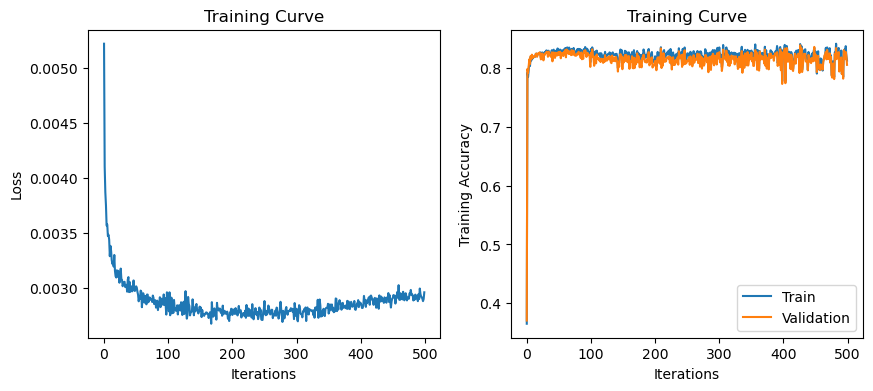

Final Training Accuracy: 0.8123673840557746
Final Validation Accuracy: 0.8050815850815851
CPU times: user 17min 58s, sys: 6min 30s, total: 24min 29s
Wall time: 14min 9s


In [32]:
%%time
train(model, train_dataset, val_dataset, num_epochs=500, learn_rate=0.0001, weight_decay=0.02, batch_size=128)

In [33]:
# saving model to file
state_dict = model.state_dict()
torch.save(state_dict, "neural_net.tar")

## Test predictions

In [34]:
# testing
test_df = pd.read_csv('test_data.csv')

In [35]:
test_df['TimeToBusStop'] = test_df['TimeToBusStop'].map({'0~5min': 1, '5min~10min': 2, '10min~15min': 3})
test_df['TimeToSubway'] = test_df['TimeToSubway'].map({'0-5min': 1, '5min~10min': 2, '10min~15min': 3, '15min~20min': 4, 'no_bus_stop_nearby': 5})

In [36]:
test_numerical_data = torch.from_numpy(test_df[numerical_features].values).float()
test_categorical_data = torch.from_numpy(categorical_pipeline.transform(test_df[categorical_features])).float()
# test_targets = torch.from_numpy(test_df[target].values.astype(np.dtype('int64')))

In [37]:
test_numerical_data,test_categorical_data = test_numerical_data.to(device), test_categorical_data.to(device)

In [38]:
# predictions for test
pred = model(test_numerical_data, test_categorical_data)
pred = pred.max(1, keepdim=True)[1]

In [39]:
# saving predictions to file
df_pred = pd.DataFrame(pred.cpu().numpy())
df_pred.to_csv('preds.csv', header=False, index=False)

## Val predictions

In [40]:
val_numerical_data, val_categorical_data = val_numerical_data.to(device), val_categorical_data.to(device)

In [41]:
# predictions for val
pred_val = model(val_numerical_data, val_categorical_data)
pred_val = pred_val.max(1, keepdim=True)[1]

In [42]:
# report for validation set
from sklearn.metrics import classification_report
print(classification_report(pred_val.cpu(), val_targets))

              precision    recall  f1-score   support

           0       0.92      0.64      0.75       177
           1       0.79      0.96      0.87       490
           2       0.90      0.61      0.73       158

    accuracy                           0.82       825
   macro avg       0.87      0.74      0.78       825
weighted avg       0.84      0.82      0.82       825



In [43]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(val_targets, pred_val.cpu())
matrix.diagonal()/matrix.sum(axis=1)

array([0.91869919, 0.78956229, 0.89814815])

<AxesSubplot: >

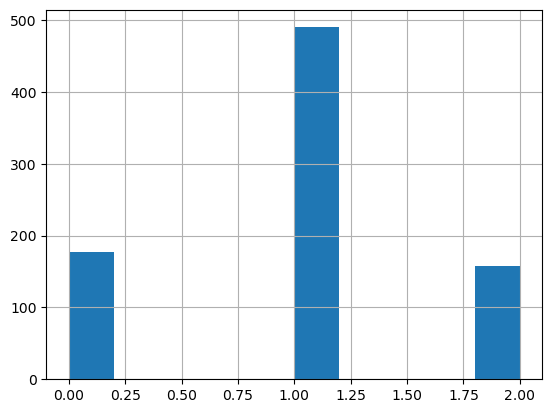

In [44]:
pd.Series(pred_val.squeeze()).hist()

<AxesSubplot: >

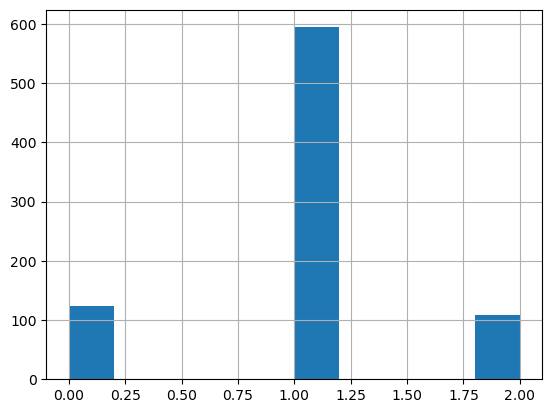

In [45]:
pd.Series(val_targets).hist()

## Hyperparameters tuning
accuracy for different layers' sizes

In [46]:
def train_search(model, train, valid, batch_size=128, num_epochs=10, learn_rate=0.001, weight_decay=0.02):
    train_loader = torch.utils.data.DataLoader(train,
                                               batch_size=batch_size,
                                               shuffle=True) # shuffle after every epoch
    classes_weights = torch.tensor(np.array([1.75, 1, 3.5]).astype('float32')).to(device)
    criterion = nn.CrossEntropyLoss(weight=classes_weights)
    optimizer = optim.Adam(model.parameters(),lr=learn_rate, weight_decay=weight_decay )
#     optimizer = optim.SGD(model.parameters(), lr=learn_rate,momentum=0.9, weight_decay=weight_decay)

    # training
    model = model.to(device)

    for n in range(num_epochs):
        epoch_loss = 0
        train_accuracy = 0
        val_accuracy = 0
        printing = True
        for x, cat_x, labels in iter(train_loader):
            model.train() 
            x, cat_x, labels = x.to(device), cat_x.to(device), labels.to(device)
            out = model(x, cat_x).squeeze() # unsqueeze(dim=2)        # forward pass
            # print('OUT', out)
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         

            # save the current training information
            
            epoch_loss += float(loss)
            # losses.append(float(loss)/batch_size)        # compute *average* loss
            # train_acc.append(get_accuracy(model, train)) # compute training accuracy 
            # val_acc.append(get_accuracy(model, valid))   # compute validation accuracy
            train_accuracy += get_accuracy(model, train)
            val_accuracy += get_accuracy(model, valid)
            
            
        new_train_acc = train_accuracy/len(train_loader)
        new_val_acc = val_accuracy/len(train_loader)
        
        if n%5==0:
            print(f"Epoch {n}, train_acc={round(new_train_acc, 2)}, val_acc={round(new_val_acc, 2)}")

    return(new_val_acc)

In [47]:
first_layer = [100, 50, 10, 1]
second_layer = [100, 50, 10, 1]
results = pd.DataFrame()
for i in range(len(first_layer)):
    for j in range(len(second_layer)):
        model = Classifier(size_1=first_layer[i], size_2=second_layer[j])
        val_acc = train_search(model, train_dataset, val_dataset)
        print(first_layer[i],second_layer[j],val_acc)
        results = results.append({"first": first_layer[i], "second": second_layer[j],"acc":val_acc},ignore_index=True)

Epoch 0, train_acc=0.64, val_acc=0.64
Epoch 5, train_acc=0.75, val_acc=0.75
100 100 0.7945454545454544


/var/folders/v7/7b5vyv797kg9pf47h5zx_wxr0000gn/T/ipykernel_12729/2568396337.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"first": first_layer[i], "second": second_layer[j],"acc":val_acc},ignore_index=True)


Epoch 0, train_acc=0.55, val_acc=0.54
